# Введение

In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json
token ={"username":"eileven","key":"9daf0059cd23de2f4d9f98c8b2ea732d"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n recsys-iad-ёchallenge -v{/content}

- recsys-iad-ёchallenge is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
! kaggle competitions download -c recsys-iad-challenge


 46% 5.00M/10.9M [00:00<00:00, 15.0MB/s]
100% 10.9M/10.9M [00:00<00:00, 24.7MB/s]
 92% 217M/235M [00:05<00:00, 31.6MB/s]
100% 235M/235M [00:05<00:00, 48.1MB/s]
 96% 355M/368M [00:03<00:00, 90.1MB/s]
100% 368M/368M [00:03<00:00, 99.7MB/s]


In [0]:
!ls
!unzip items.json.zip
!unzip train.json
!unzip random_benchmark.csv.zip

drive  items.json.zip  random_benchmark.csv.zip  sample_data  train.json.zip
Archive:  items.json.zip
  inflating: items.json              
Archive:  train.json.zip
  inflating: train.json              
Archive:  random_benchmark.csv.zip
  inflating: random_benchmark.csv    


In [0]:

%%time
import numpy as np
import pandas as pd
import json
from tqdm.auto import tqdm 
image = []
items_list=[]
with tqdm(open('items.json')) as inf:
    for line in inf:
        item=json.loads(line)
        if isinstance(item['image'], float):
            item['image']=[0 for _ in range(96)]
            
        item['image']=np.array(item['image'])
        items_list.append(item)
        image.append(item['image'])

items=pd.DataFrame(items_list).set_index('itemId')


CPU times: user 14.7 s, sys: 1.9 s, total: 16.6 s
Wall time: 16.7 s


# Предобрботка текста

In [0]:
!pip install pymorphy2

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
import pymorphy2
import re

In [0]:
morph = pymorphy2.MorphAnalyzer()
def punct (text):
  text = ''.join(c for c in text if c not in punctuation)
  return text
def stop_words (text):
  text = ([word for word in text.split() if word not in stopwords.words('russian')])
  return text
def get_normal_form(word, analyzer=morph):
    '''
    возвращает слово в нормальной форме (инфинитив, именительный падеж, муж род...)
    приставки, частицы, числа удаляет
    '''
    forms = analyzer.parse(word)
    try:
        form = max(forms, key=lambda x: (x.score, x.methods_stack[0][2]))
    except IndexError:
        form = forms[0]
    if form.tag.POS not in ['PREP', 'CONJ', 'PRCL', 'NPRO', 'NUMR']:
        norm_word = form.normal_form.replace("ё", "е")
        return norm_word
    return ''
def sentence_to_wordlist(text, norm = True):
    '''
    преобразует все слова в предложении к нормальной форме
    '''
    if norm:
        return [get_normal_form(w) for w in text.split()]
    else:
        return [w for w in text.split()]
def letter_to_bow(letter, norm = True):
    '''
    преобразует все слова в письме в "мешок" нормализованных слов 
    '''
    norm_sents = [sentence_to_wordlist(sent, norm) for sent in letter]
    bow = ' '.join([word for sent in norm_sents for word in sent if word != ''])
    bow = re.sub(' не ', ' не', bow)
    bow = re.sub('^не ', 'не', bow)
    return bow
def work_with_sent(sent):
    bow = ' '.join([word for word in sent if word != ''])
    bow = re.sub(' не ', ' не', bow)
    bow = re.sub('^не ', 'не', bow)
    return bow

def letter_to_norm_sent(letter, norm = True):
    '''
    преобразует все слова в письме в "мешок" нормализованных слов 
    '''
    norm_sents = [sentence_to_wordlist(sent, norm) for sent in letter]
    joined_norm_sents = [work_with_sent(sent) for sent in norm_sents]
        
    return joined_norm_sents
r = re.compile("[а-яА-Я]+")
def rus_only (text):
  text = [w for w in filter(r.match, text)]
  return text

In [0]:
items['title'] = items['title'].apply(punct)
items['title'] = items['title'].apply(stop_words)
items['title'] = items['title'].apply(letter_to_norm_sent)
items['title'] = items['title'].apply(rus_only)

In [0]:
items.to_pickle('./title_prep.pkl')
!cp title_prep.pkl "drive/My Drive/"

In [0]:
items['content'] = items['content'].apply(punct)
items['content'] = items['content'].apply(stop_words)
items['content'] = items['content'].apply(letter_to_norm_sent)
items['content'] = items['content'].apply(rus_only)

In [0]:
tit = pd.read_pickle('/content/drive/My Drive/title_prep.pkl')
cont = pd.read_pickle('/content/drive/My Drive/alltxt_prep.pkl')

In [0]:
cont['title'] = tit['title']

In [0]:
cont.to_pickle('./final_txt.pkl')
!cp final_txt.pkl "drive/My Drive/"

In [0]:
!cp '/content/drive/My Drive/final_txt.pkl' final_txt.pkl
items_fnl = pd.read_pickle('final_txt.pkl')

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
title=[]
for i in items_fnl['title']:
  title.append(' '.join(i))

In [0]:
content=[]
for i in items_fnl['content']:
  content.append(' '.join(i))

In [0]:
vectorizer = TfidfVectorizer(lowercase=False, min_df=10, max_df=0.01)
tfidf_titles = vectorizer.fit_transform(title)
tfidf_content = vectorizer.fit_transform(content)

# Предобработка картинок + сбор фитчей

In [0]:
a = np.vstack(items.image)

In [0]:
from scipy import sparse 
img = sparse.csr_matrix(a)

In [0]:
item_features = sparse.hstack([tfidf_content, tfidf_titles, img])


# Выгрузка трейна

In [0]:
user_ids = []
item_ids = []
ratings = []
random_benchmark = pd.read_csv('random_benchmark.csv')
with tqdm(open('train.json')) as f:
    for i, line in enumerate(f):
        train_line = json.loads(line)
        for j, (key, value) in enumerate(train_line['trainRatings'].items()):
            user_ids.append(train_line['userId'])
            item_ids.append(int(key))
            if value==1:
              ratings.append(value)
            else:
              ratings.append(-1)

In [0]:
lfm = sparse.coo_matrix((ratings, (user_ids, item_ids)))

# LighFm

In [0]:
!pip install lightfm
from lightfm import LightFM


     |████████████████████████████████| 307kB 2.8MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707634 sha256=272bb104d71ef59879555cd0a91b3e7444e0c1e30b51e785204000d22294cf3c
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [0]:
model_ratings = LightFM(loss = 'logistic', learning_schedule='adagrad')
model_ratings.fit(lfm_train_spr,epochs =10, num_threads=4)
#модель только на оценках

In [0]:
model = LightFM(loss = 'logistic', learning_schedule='adagrad')
model.fit_partial(lfm,item_features=item_features, epochs = 10, num_threads=4)

In [0]:
#альтернативный вариант не вздетел
# model = LightFM(loss = 'logistic', learning_schedule='adagrad')
# model.fit_partial(lfm,item_features=item_features,user_features = tge_sparse.T, epochs = 2, num_threads=4)

In [0]:
subm1 = pd.read_csv('random_benchmark.csv')
subm1['pred']=model.predict(subm1.userId.values,subm1.itemId.values, item_features = item_features,user_features=tge_sparse.T, num_threads=4)
subm1.sort_values(["userId", "pred"], ascending=[True, False], inplace=True) 
subm1.drop(columns=['pred'],inplace=True)

In [0]:
subm1.to_csv('test.csv', index = False)
!kaggle competitions submit -c recsys-iad-challenge -f test.csv -m "Message"

100% 35.7M/35.7M [00:08<00:00, 4.41MB/s]
Successfully submitted to Articles RecSys

In [0]:
import joblib

In [0]:
filename = '/content/drive/My Drive/lightfm.sav'
filename_ratings = '/content/drive/My Drive/lightfm_ratings.sav'
# joblib.dump(model, filename )

In [0]:
model = joblib.load(filename)
model_ratings = joblib.load(filename_ratings)

# Catboost (не вошло в финальную модель)
Не вошло в модель

In [0]:
user_embeddings = model.user_embeddings
user_bias = model.user_biases
item_embeddings = model_ratings.item_embeddings
item_bias = model_ratings.item_biases
#берем вектора

In [0]:
import numpy as np
import pandas as pd
import json
from tqdm.auto import tqdm 


In [0]:
user_ids = []
item_ids = []
ratings = []
random_benchmark = pd.read_csv('random_benchmark.csv')
users_test = random_benchmark.userId.unique()
with tqdm(open('train.json')) as f:
    for i, line in enumerate(f):
        train_line = json.loads(line)
        for j, (key, value) in enumerate(train_line['trainRatings'].items()):
            user_ids.append(train_line['userId'])
            item_ids.append(int(key))
            ratings.append(value)
df = pd.DataFrame({'user_id':user_ids, 'itemId':item_ids,'rating':ratings})

In [0]:
df_test = df.loc[df['user_id'].isin(users_test)]
#выбираем юзеров, которые только в random_bench

In [0]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.3MB/s 


In [0]:
from category_encoders.target_encoder import TargetEncoder

In [0]:
tge = TargetEncoder(cols = ['user_id'])
tge.fit(df.user_id,df.rating)
tge.trans = tge.transform(df.user_id,df.rating)
#создаем очень важную фичу, ее добавим после всего, ибо надо будет выбрать нужную

In [0]:
df['tge'] = tge.trans

In [0]:
df_nodub = df.drop_duplicates(['user_id'])

In [0]:
tge_sparse = np.array(df_nodub.tge)
tge_sparse = sparse.csr_matrix(tge_sparse)


In [0]:
df_user_embedding = pd.DataFrame(user_embeddings[users_test], index=users_test)
df_user_bias = pd.DataFrame(user_bias[users_test], index=users_test)
df_item_embedding = pd.DataFrame(item_embeddings,index = df_test_items.index)
df_item_bias= pd.DataFrame(item_bias,index = df_test_items.index)
#создаем из эмбендингов датафреймы

NameError: ignored

In [0]:
dict_ = pd.Series(df.user_id,index=df.rating).to_dict() #так себе идея/забей

In [0]:
groups = df.groupby('itemId')

In [0]:
mean = groups['rating'].mean()
sum_ = groups['rating'].sum()
freq = groups.count()/len(users_test)
#считаем статистики по юзерам и айтемам 

In [0]:
df_mean=pd.DataFrame({'mean':mean.values,'itemId':mean.index})
df_freq = pd.DataFrame({'freq':freq['rating'].values,'itemId':freq.index})

In [0]:
drop_freq = list(df_mean[df_mean['mean']==0]['itemId'].values)

In [0]:
df_mean[df_mean['mean']==0]['itemId'].values

array([     6,     11,     13, ..., 328012, 328035, 328038])

In [0]:
df = df.merge(df_mean,how='left',on='itemId')

0.0848303724816836


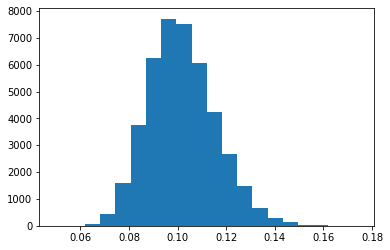

In [0]:
import matplotlib.pyplot as plt
array_1=df.groupby('user_id')['mean'].mean().values #генерация новой выборки бутстрапом из моего распеределения
plt.hist(array_1, bins=20)
#надо посчитать квантили и на основе этого присваивать статус фрик, норм чел,популярный, над порогом надо подумать
low = np.percentile(array_1,10)
hight = np.percentile(array_1,90)
print(low)

In [0]:
labuda = df.groupby('user_id')['mean'].mean()
labuda.low = labuda.where(labuda.values<low)
labuda.hight = labuda.where(labuda.values>hight)

In [0]:
index_low = list(labuda.low.dropna().index)
index_hight = list(labuda.hight.dropna().index)
index_low = [x for x in index_low if x in df_test.user_id.unique()]
index_hight = [x for x in index_hight if x in df_test.user_id.unique()]

In [0]:
df_test['user_type'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_test.loc[df['user_id'].isin(index_low),['user_type']] = 2
df_test.loc[df['user_id'].isin(index_hight),['user_type']] = 3
#или просто 0,1,2- надо подумать 


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
df_test['user_id'] = tge.trans

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_test

,user_id,itemId,rating,user_type
4163,0.113675,180165,0,1
4164,0.113675,286761,1,1
4165,0.113675,127012,1,1
4166,0.113675,117072,0,1
4167,0.113675,86362,0,1
...,...,...,...,...
67775685,0.036214,212700,0,1
67775686,0.036214,113138,0,1
67775687,0.036214,198779,0,1
67775688,0.036214,125091,0,1


Собираем все в один датафрейм для айтемов



In [0]:
items = items.merge(df_item_embedding,how='left',on='itemId')
items = items.merge(df_item_bias,how='left',on='itemId')
items = items.merge(df_mean,how='left',on='itemId')
items = items.merge(df_freq, how='left', on='itemId')
#тут надо дропнуть или заменить значения 0 для тех айтемов, с которыми вообще ничего не делали 

Собираем текст заголовков

In [0]:
items_fnl['title'] = title
items_fnl['title']

In [0]:
!git clone https://github.com/facebookresearch/fastText.git
!pip3 install fastText/.

fatal: destination path 'fastText' already exists and is not an empty directory.
Processing ./fastText
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2855666 sha256=204505029a5550f3b33c998d4c91dc7e37ce3c999be659ec4820aa9e3d73d0bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-7cj6cfab/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
  Found existing installation: fasttext 0.9.1
    Uninstalling fasttext-0.9.1:
      Successfully uninstalled fasttext-0.9.1


In [0]:
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore') 
ft = fasttext.load_model('cc.ru.300.bin')

In [0]:
from nltk import tokenize
tokenizer = tokenize.TweetTokenizer()
def w2v (text_):
    text_ = tokenizer.tokenize(text_)
    vector = np.array([ft[word] for word in text_]).mean(axis=0)
    return vector

In [0]:
items_fnl['title_w2v'] = items_fnl['title'].apply(w2v)
# items['conten_w2v'] = items['content'].apply(w2v)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


In [0]:
items_fnl.to_pickle('./items_w2v.pkl')
!cp items_w2v.pkl "drive/My Drive/"

In [0]:
!cp '/content/drive/My Drive/items_w2v.pkl' items_w2v.pkl
items_fnl = pd.read_pickle('items_w2v.pkl')

In [0]:
title_df = pd.DataFrame(items_fnl['title_w2v'].values,columns=['tit'], index = items_fnl.index)

In [0]:
#Собрали индексы пропущенных тайтлов
a = pd.isna(title_df)
a = a.sort_values(by = ['tit'], ascending=True)
a = a.loc[lambda a: a['tit'] == True, :]
c = list(a.index)

In [0]:
#Заменяем на список из нулей пропущенные векторы
title_df['user_id'] = title_df.index.values
not_nun = title_df.loc[title_df['user_id'].isin(c)==False,['tit']]
nun = title_df.loc[title_df['user_id'].isin(c),['tit']]
nun = pd.DataFrame(nun['tit'].apply(lambda x: [0]*300), index = nun.index, columns=['tit'])
title_df = pd.DataFrame(pd.concat([not_nun,nun]))
title_df['user_id'] = title_df.index.values
title_df = title_df.sort_values(by = 'user_id')

In [0]:
#Разбиваем на колонки
a = np.vstack(title_df.tit)
title_df = pd.DataFrame(a)
title_df.columns = [str(i)+'tit' for i in range(0,300)]

In [0]:
title_df

,0tit,1tit,2tit,3tit,4tit,5tit,6tit,7tit,8tit,9tit,10tit,11tit,12tit,13tit,14tit,15tit,16tit,17tit,18tit,19tit,20tit,21tit,22tit,23tit,24tit,25tit,26tit,27tit,28tit,29tit,30tit,31tit,32tit,33tit,34tit,35tit,36tit,37tit,38tit,39tit,...,260tit,261tit,262tit,263tit,264tit,265tit,266tit,267tit,268tit,269tit,270tit,271tit,272tit,273tit,274tit,275tit,276tit,277tit,278tit,279tit,280tit,281tit,282tit,283tit,284tit,285tit,286tit,287tit,288tit,289tit,290tit,291tit,292tit,293tit,294tit,295tit,296tit,297tit,298tit,299tit
0,0.086139,0.038717,-0.058791,0.051727,-0.020813,-0.036456,0.053259,-0.042227,-0.066553,-0.001402,0.050415,0.036994,0.037499,-0.023555,-0.044291,0.002529,-0.025707,0.017120,-0.095710,0.006057,-0.016924,-0.043218,-0.012561,0.022402,0.048262,0.021027,0.008669,-0.093522,0.050068,0.072431,0.002438,-0.039062,0.030734,-0.047162,0.005656,0.006414,-0.028480,-0.103003,-0.044939,-0.041029,...,0.021153,0.001918,-0.048424,-0.038982,-0.012121,-0.040338,-0.023211,-0.000810,-0.008410,0.021942,0.043974,0.045964,0.095310,0.016767,0.043806,0.036835,0.010314,-0.025645,0.026157,-0.025978,-0.033225,0.006406,0.001311,0.002463,-0.066977,0.004740,0.010897,0.049899,0.011534,0.032416,-0.017959,-0.029899,0.023139,-0.053272,-0.008474,0.005118,-0.012480,0.032961,-0.016067,0.001783
1,0.017822,-0.053321,-0.011257,0.007534,0.027275,-0.020514,0.009979,-0.004079,-0.012767,0.001467,0.027548,0.030868,-0.005554,-0.005476,-0.024118,0.017718,-0.020366,0.001543,0.023181,-0.013900,0.010154,-0.008161,0.017258,0.015573,0.004245,-0.010654,0.018457,-0.034629,0.051395,0.000911,0.059399,-0.012533,-0.000926,-0.004781,0.012848,-0.000865,-0.019237,-0.107775,-0.035010,-0.010737,...,0.028018,0.078218,-0.070509,-0.006075,-0.021315,-0.032270,0.018864,0.016129,-0.042013,-0.010338,0.035647,-0.031783,0.118235,-0.028735,-0.004465,-0.021490,-0.001894,-0.030049,-0.012725,-0.021044,-0.002334,-0.016393,-0.014339,-0.024200,-0.003972,0.004829,0.035111,0.018805,0.000868,-0.023104,0.012139,-0.035781,-0.064631,-0.033305,0.046573,-0.000364,0.049901,-0.038046,0.010729,-0.038816
2,0.053837,-0.019301,-0.009579,0.028419,0.019595,-0.015023,0.023419,0.009460,-0.011487,0.011761,-0.020517,-0.004103,-0.012559,0.017589,-0.014573,0.017535,-0.017953,0.016872,-0.035003,0.017676,-0.002613,-0.050912,0.008139,0.022908,0.021033,0.020455,-0.004403,-0.008116,0.016795,-0.013339,-0.012485,0.008914,-0.031489,0.003325,0.028521,-0.018618,-0.021600,-0.120353,-0.024604,0.025415,...,-0.002166,0.030305,-0.069735,-0.042219,0.082001,-0.048023,0.034139,0.011442,0.024789,-0.028514,0.070095,0.009234,0.089507,-0.006310,0.022560,-0.035753,-0.011163,-0.022654,0.024387,-0.013599,-0.036287,-0.010749,-0.020079,0.000812,-0.001561,-0.018528,-0.012186,-0.012883,-0.012033,-0.015692,-0.012442,-0.023854,0.007445,-0.051971,-0.021698,0.003193,0.014585,-0.008351,-0.004183,-0.014059
3,0.032290,-0.011298,-0.030498,-0.026422,-0.013028,0.070246,-0.012317,-0.060084,-0.023317,-0.026593,0.034713,0.002258,-0.013413,-0.021842,0.018242,0.011701,0.007888,-0.002435,0.005130,-0.020855,0.011486,-0.017211,-0.024518,0.027696,0.002908,-0.044886,0.010712,0.022803,0.020009,-0.005970,0.045328,-0.000575,0.001261,-0.025726,0.020225,-0.011725,-0.032781,-0.091605,-0.023103,-0.020225,...,0.024517,-0.003974,-0.017748,-0.021353,-0.019128,0.011829,0.003531,0.007734,-0.005748,0.012078,0.015969,-0.049498,0.093770,0.012322,0.025135,0.014680,-0.015283,-0.068909,0.049689,-0.008869,-0.029786,-0.006577,-0.022594,0.012812,-0.033781,0.013443,-0.013807,-0.049968,-0.032157,0.026207,-0.023753,-0.005576,-0.004450,-0.003673,-0.007484,-0.059651,0.006577,0.015426,-0.016755,-0.012308
4,0.004053,-0.047840,0.033122,0.030332,0.033283,-0.033915,-0.022195,-0.018950,0.004201,-0.012470,-0.016917,0.016516,-0.001816,-0.008599,0.006902,-0.027022,0.047189,-0.004536,-0.034750,0.001079,0.009907,-0.067361,0.023105,0.008352,0.047906,-0.009523,0.015455,0.014810,0.031367,0.014076,0.021984,-0.032165,-0.009432,-0.021720,0.035620,0.009584,0.015251,-0.109082,0.024267,0.007642,...,-0.009392,-0.023081,

Кажется, что фасттекст на контенте будет слишком долог. В качестве признака контекста просто вернем количество слов

In [0]:
content_df = pd.DataFrame(items_fnl['content'].values,columns=['content'], index = items_fnl.index)

In [0]:
content_df['content'] = content_df['content'].apply(lambda x: len(x))

In [0]:
content_df

,content
itemId,
0,181
1,190
2,94
3,130
4,187
...,...
328045,59
328046,125
328047,141


Наконец, перейдём к картинкам, но тут ничего интересного не будет)

In [0]:
image_df = pd.DataFrame(items_fnl['image'].values,columns=['image'], index = items_fnl.index)

In [0]:
a = np.vstack(image_df.image)
image_df = pd.DataFrame(a)
image_df.columns = [str(i)+'im' for i in range(0,96)]

In [0]:
image_df

,0im,1im,2im,3im,4im,5im,6im,7im,8im,9im,10im,11im,12im,13im,14im,15im,16im,17im,18im,19im,20im,21im,22im,23im,24im,25im,26im,27im,28im,29im,30im,31im,32im,33im,34im,35im,36im,37im,38im,39im,...,56im,57im,58im,59im,60im,61im,62im,63im,64im,65im,66im,67im,68im,69im,70im,71im,72im,73im,74im,75im,76im,77im,78im,79im,80im,81im,82im,83im,84im,85im,86im,87im,88im,89im,90im,91im,92im,93im,94im,95im
0,-0.169,0.129,0.067,0.019,0.281,-0.245,0.089,0.329,0.072,-0.334,0.623,-0.029,0.126,-0.119,-0.075,0.175,-0.065,0.058,-0.249,-0.079,-0.057,0.170,-0.136,-0.031,0.039,0.058,0.103,0.068,-0.274,-0.068,-0.205,-0.077,0.256,-0.046,-0.027,-0.192,-0.145,0.047,-0.141,0.030,...,0.099,-0.224,0.038,0.176,-0.078,0.292,0.256,-0.131,-0.055,0.040,0.330,0.330,0.146,0.332,0.139,0.178,-0.088,0.075,0.147,-0.235,-0.125,0.321,0.118,0.258,0.028,-0.397,0.008,-0.110,0.194,0.352,0.115,0.110,0.219,0.064,-0.054,-0.030,0.056,-0.428,-0.128,0.145
1,-0.158,-0.112,-0.325,0.050,-0.114,0.002,-0.037,-0.373,0.056,-0.088,0.015,0.221,0.115,-0.070,0.309,0.255,0.030,0.040,0.190,0.117,0.126,-0.049,0.043,0.142,0.130,-0.241,0.088,0.082,0.003,-0.135,-0.020,-0.156,-0.138,0.110,0.036,0.072,-0.174,0.274,-0.330,0.083,...,0.059,-0.447,0.121,0.202,-0.004,0.171,-0.101,0.132,-0.091,-0.056,-0.013,-0.366,-0.027,0.085,0.111,0.295,-0.080,0.008,-0.023,0.073,-0.097,-0.215,-0.369,-0.036,0.078,-0.171,-0.077,-0.010,-0.158,0.204,-0.198,-0.180,-0.055,-0.055,-0.132,0.084,-0.188,0.277,0.042,0.149
2,0.084,-0.181,0.008,0.340,-0.030,-0.197,-0.051,-0.016,-0.024,-0.310,0.041,-0.129,-0.189,-0.100,-0.121,0.013,0.149,0.021,0.025,-0.231,-0.118,0.268,-0.120,0.001,-0.021,0.162,0.002,-0.139,-0.013,0.166,0.000,-0.038,-0.083,0.112,-0.089,0.128,-0.017,-0.015,0.062,-0.128,...,-0.089,0.014,0.184,-0.122,-0.143,0.105,0.044,-0.048,0.032,-0.097,-0.132,-0.058,-0.108,-0.038,0.046,0.168,0.030,-0.055,0.002,-0.084,0.212,0.265,-0.132,-0.142,0.017,-0.118,-0.026,-0.286,0.164,-0.094,-0.284,0.012,-0.148,0.111,-0.043,0.123,0.093,-0.108,-0.359,-0.127
3,0.034,-0.119,-0.062,0.025,0.128,-0.041,0.053,-0.119,-0.071,-0.382,-0.070,-0.030,0.045,-0.093,-0.081,0.249,0.143,0.064,0.001,-0.125,-0.106,0.403,-0.224,-0.038,0.110,0.132,0.009,-0.036,0.164,0.021,0.050,0.256,0.051,0.062,-0.030,0.178,-0.002,0.218,0.090,-0.412,...,-0.004,-0.032,0.078,0.049,0.054,0.107,0.117,-0.287,0.031,0.137,-0.319,-0.055,-0.171,-0.087,-0.028,0.196,-0.017,0.045,-0.045,0.163,0.025,-0.101,-0.016,-0.147,0.087,0.079,-0.015,-0.054,-0.044,0.070,-0.044,-0.001,0.017,0.191,-0.134,-0.154,0.007,-0.033,-0.097,0.067
4,-0.061,-0.015,-0.198,-0.047,0.054,0.029,-0.091,0.091,-0.051,-0.065,-0.064,0.076,0.038,-0.059,0.179,-0.088,-0.065,-0.034,0.170,0.329,0.155,-0.250,-0.079,-0.091,0.128,0.007,-0.214,-0.023,-0.035,-0.018,-0.179,0.065,0.003,0.175,0.120,0.136,-0.017,0.122,-0.138,-0.075,...,-0.076,0.081,-0.075,-0.104,0.111,0.040,-0.304,0.207,-0.086,0.016,-0.358,-0.248,-0.200,-0.099,0.153,0.122,-0.230,0.108,-0.143,0.046,0.218,-0.090,0.120,-0.021,-0.111,-0.120,-0.061,-0.021,-0.002,0.221,0.178,-0.004,0.134,-0.125,-0.121,-0.130,-0.132,0.030,0.342,-0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328045,0.231,-0.027,-0.027,0.066,-0.245,0.098,0.023,-0.212,-0.112,0.110,-0.085,0.320,-0.005,0.109,-0.056,0.110,-0.237,0.128,0.232,0.042,0.084,-0.053,0.340,-0.054,0.076,-0.027,-0.205,-0.254,-0.107,-0.020,-0.185,-0.072,0.068,0.004,0.039,0.016,0.010,0.046,-0.249,0.124,...,-0.046,-0.075,0.022,-0.014,0.145,-0.256,-0.066,0.206,0.209,-0.219,-0.146,-0.001,0.190,0.042,0.071,0.088,-0.087,-0.199,0.039,-0.126,0.087,-0.051,-0.108,-0.031,0.288,0.055,-0.160,-0.044,0.102,-0.024,-0.248,0.410,-0.153,0.028,-0.167,0.439,-0.172,0.224,0.161,0.240
328046,-0.235,-0.309,-0.126,-0.332,0.197,-0.292,0.076,0.087,-0.228,-0.043,-0.073,0.094,0.165,0.095,0.148,-0.1

Теперь, соберем все признаки айтемов в один датафрейм

In [0]:
df_test_items = title_df.join([content_df, image_df])
df_test_items.set_index(items_fnl.index)

,0tit,1tit,2tit,3tit,4tit,5tit,6tit,7tit,8tit,9tit,10tit,11tit,12tit,13tit,14tit,15tit,16tit,17tit,18tit,19tit,20tit,21tit,22tit,23tit,24tit,25tit,26tit,27tit,28tit,29tit,30tit,31tit,32tit,33tit,34tit,35tit,36tit,37tit,38tit,39tit,...,56im,57im,58im,59im,60im,61im,62im,63im,64im,65im,66im,67im,68im,69im,70im,71im,72im,73im,74im,75im,76im,77im,78im,79im,80im,81im,82im,83im,84im,85im,86im,87im,88im,89im,90im,91im,92im,93im,94im,95im
itemId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.086139,0.038717,-0.058791,0.051727,-0.020813,-0.036456,0.053259,-0.042227,-0.066553,-0.001402,0.050415,0.036994,0.037499,-0.023555,-0.044291,0.002529,-0.025707,0.017120,-0.095710,0.006057,-0.016924,-0.043218,-0.012561,0.022402,0.048262,0.021027,0.008669,-0.093522,0.050068,0.072431,0.002438,-0.039062,0.030734,-0.047162,0.005656,0.006414,-0.028480,-0.103003,-0.044939,-0.041029,...,0.099,-0.224,0.038,0.176,-0.078,0.292,0.256,-0.131,-0.055,0.040,0.330,0.330,0.146,0.332,0.139,0.178,-0.088,0.075,0.147,-0.235,-0.125,0.321,0.118,0.258,0.028,-0.397,0.008,-0.110,0.194,0.352,0.115,0.110,0.219,0.064,-0.054,-0.030,0.056,-0.428,-0.128,0.145
1,0.017822,-0.053321,-0.011257,0.007534,0.027275,-0.020514,0.009979,-0.004079,-0.012767,0.001467,0.027548,0.030868,-0.005554,-0.005476,-0.024118,0.017718,-0.020366,0.001543,0.023181,-0.013900,0.010154,-0.008161,0.017258,0.015573,0.004245,-0.010654,0.018457,-0.034629,0.051395,0.000911,0.059399,-0.012533,-0.000926,-0.004781,0.012848,-0.000865,-0.019237,-0.107775,-0.035010,-0.010737,...,0.059,-0.447,0.121,0.202,-0.004,0.171,-0.101,0.132,-0.091,-0.056,-0.013,-0.366,-0.027,0.085,0.111,0.295,-0.080,0.008,-0.023,0.073,-0.097,-0.215,-0.369,-0.036,0.078,-0.171,-0.077,-0.010,-0.158,0.204,-0.198,-0.180,-0.055,-0.055,-0.132,0.084,-0.188,0.277,0.042,0.149
2,0.053837,-0.019301,-0.009579,0.028419,0.019595,-0.015023,0.023419,0.009460,-0.011487,0.011761,-0.020517,-0.004103,-0.012559,0.017589,-0.014573,0.017535,-0.017953,0.016872,-0.035003,0.017676,-0.002613,-0.050912,0.008139,0.022908,0.021033,0.020455,-0.004403,-0.008116,0.016795,-0.013339,-0.012485,0.008914,-0.031489,0.003325,0.028521,-0.018618,-0.021600,-0.120353,-0.024604,0.025415,...,-0.089,0.014,0.184,-0.122,-0.143,0.105,0.044,-0.048,0.032,-0.097,-0.132,-0.058,-0.108,-0.038,0.046,0.168,0.030,-0.055,0.002,-0.084,0.212,0.265,-0.132,-0.142,0.017,-0.118,-0.026,-0.286,0.164,-0.094,-0.284,0.012,-0.148,0.111,-0.043,0.123,0.093,-0.108,-0.359,-0.127
3,0.032290,-0.011298,-0.030498,-0.026422,-0.013028,0.070246,-0.012317,-0.060084,-0.023317,-0.026593,0.034713,0.002258,-0.013413,-0.021842,0.018242,0.011701,0.007888,-0.002435,0.005130,-0.020855,0.011486,-0.017211,-0.024518,0.027696,0.002908,-0.044886,0.010712,0.022803,0.020009,-0.005970,0.045328,-0.000575,0.001261,-0.025726,0.020225,-0.011725,-0.032781,-0.091605,-0.023103,-0.020225,...,-0.004,-0.032,0.078,0.049,0.054,0.107,0.117,-0.287,0.031,0.137,-0.319,-0.055,-0.171,-0.087,-0.028,0.196,-0.017,0.045,-0.045,0.163,0.025,-0.101,-0.016,-0.147,0.087,0.079,-0.015,-0.054,-0.044,0.070,-0.044,-0.001,0.017,0.191,-0.134,-0.154,0.007,-0.033,-0.097,0.067
4,0.004053,-0.047840,0.033122,0.030332,0.033283,-0.033915,-0.022195,-0.018950,0.004201,-0.012470,-0.016917,0.016516,-0.001816,-0.008599,0.006902,-0.027022,0.047189,-0.004536,-0.034750,0.001079,0.009907,-0.067361,0.023105,0.008352,0.047906,-0.009523,0.015455,0.014810,0.031367,0.014076,0.021984,-0.032165,-0.009432,-0.021720,0.035620,0.009584,0.015251,-0.109082,0.024267,0.007642,...,-0.076,0.081,-0.075,-0.104,0.111,0.040,-0.304,0.207,-0.086,0.016,-0.358,-0.248,-0.200,-0.099,0.153,0.122,-0.230,0.108,-0.143,0.046,0.218,-0.090,0.120,-0.021,-0.111,-0.120,-0.061,-0.021,-0.002,0.221,0.178,-0.004,0.134,-0.125,-0.121,-0.130,-0.132,0.030,0.342,-0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
# df_test_items.to_pickle('./df_test_items.pkl')
# !cp df_test_items.pkl "drive/My Drive/"

In [0]:
import pandas as pd
!cp '/content/drive/My Drive/df_test_items.pkl' df_test_items.pkl
df_test_items = pd.read_pickle('df_test_items.pkl')

In [0]:
#То что удаляем, потому, что нихера нет
a = df_test_items[df_test_items['content']==0]
b = a[a['0im']==0]
с = b.index

In [0]:
df_test_items['itemId'] = df_test_items.index

In [0]:
df_item_embedding['itemId'] = df_test_items.index
df_item_bias['itemId'] = df_test_items.index

In [0]:
df_test_items = df_test_items.merge(df_item_embedding,how='left',on='itemId')
df_test_items = df_test_items.merge(df_item_bias,how='left',on='itemId')
# items = items.merge(df_mean,how='left',on='itemId')
# items = items.merge(df_freq, how='left', on='itemId')

In [0]:
# df_test_items.to_pickle('/content/drive/My Drive/df_test_items_1.pkl')
# df_test.to_pickle('/content/drive/My Drive/df_test.pkl')

In [0]:
import pandas as pd
!cp '/content/drive/My Drive/df_test_items_1.pkl' df_test_items_1.pkl
df_test_items_1 = pd.read_pickle('df_test_items_1.pkl')

In [0]:
import pandas as pd
!cp '/content/drive/My Drive/df_test.pkl' df_test.pkl
df_test = pd.read_pickle('df_test.pkl')

In [0]:
X = df_test.drop('rating',1)
y = df_test['rating']

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [0]:
X_test1,X_test2,y_test1,y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# X_train1, X_train2,y_train1,y_train2 = train_test_split(X_train,y_train, test_size=0.5, random_state=42)

In [0]:
X_test1 = X_test1.merge(df_test_items_1,how = 'left', on = 'itemId')
# X_test2 = X_test2.merge(df_test_items_1,how = 'left', on = 'itemId')

In [0]:
# X_train1 = X_train1.merge(df_test_items_1,how = 'left', on = 'itemId')

In [0]:
# X_test = X_test.merge(df_test_items_1,how = 'left', on = 'itemId')

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
model_sgd = SGDClassifier(loss='log')

In [0]:
model_sgd.partial_fit(X_test1,y_test1,classes=[0,1])
# model_sgd.partial_fit(X_test2,y_test2,classes = [0,1])


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
subm1 = pd.read_csv('random_benchmark.csv')


In [0]:
subm1.shape

(3018186, 2)

In [0]:
import joblib